In [123]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import xray as xr
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

%matplotlib inline

import sys
sys.path.append("/Users/tj/repos/pydownscale/")
from pydownscale.MSSL import pMSSL
from pydownscale.data import DownscaleData
from pydownscale.utils import RootTransform


In [2]:
data = pickle.load(open("newengland_D_12781_8835.pkl", "r"))



In [124]:
max_train_year = 2004
seas = "JJA"
seasonidxs = np.where(data.observations['time.season'] == seas)[0]
X = data.get_XTensor()[seasonidxs]
Y, locs = data.get_y()
Y = Y[seasonidxs]
t = data.observations['time'][seasonidxs]

train_rows = np.where(t['time.year'] <= max_train_year)[0]
test_rows = np.where(t['time.year'] > max_train_year)[0]
ttest = t[test_rows]

Xtrain, Xtest = X[train_rows], X[test_rows]
YtrainTrue, YtestTrue = Y[train_rows], Y[test_rows]

Xmu, Xsd = Xtrain.mean(axis=0), Xtrain.std(axis=0)
Xtrain = (Xtrain - Xmu) / Xsd
Xtest = (Xtest - Xmu) / Xsd

scale_y = RootTransform(0.25)
scale_y.fit(YtrainTrue)
Ytrain = scale_y.transform(YtrainTrue)
Ytest = scale_y.transform(YtestTrue)

print Ytrain.shape, Xtrain.shape




(2300, 266) (2300, 19, 31, 15)


In [125]:
#As per Section 3.2, we set f1 = 9, f3 = 5, n1 = 64 
#    and n2 = 32 in our main evaluations
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def max_pool_3x3(x):
  return tf.nn.max_pool(x, ksize=[1, 3, 3, 1],
                        strides=[1, 3, 3, 1], padding='SAME')

def max_pool_6x6(x):
  return tf.nn.max_pool(x, ksize=[1, 3, 3, 1],
                        strides=[1, 3, 3, 1], padding='SAME')


# First Convolution Layer

$W_1 = c \times f_1 \times f_1 \times n_1$

$B_1$ is of length $n_1$

In [153]:
class CNNDownscale:
    def __init__(self, how='regression', sess=None):
        self.how = how
        self.sess = sess
        if self.sess is None:
            self.sess = tf.InteractiveSession()
            
    
    def fit(self, X, y):
        c0 = 15  # number of input channels
        c1 = 5
        c2 = 1
        
        numt, numx, numy, numc = X.shape
        
        self.x_ = tf.placeholder(tf.float32, shape=[None, numx, numy, numc])
        self.y_ = tf.placeholder(tf.float32, shape=[None, y.shape[1]])

        W_conv1 = weight_variable([3, 3, c0, c1])
        b_conv1 = bias_variable([c1])
        h_conv1 = tf.nn.relu(conv2d(self.x_, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)

        W_conv2 = weight_variable([3, 3, c1, c2])
        b_conv2 = bias_variable([c2])
        h_conv2 =  tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)

        _, d1, d2, d3 = h_pool2.get_shape()
        h2units = d1.value * d2.value * d3.value
        h_pool2_flat = tf.reshape(h_pool2, [-1, h2units])

        self.keep_prob = tf.placeholder(tf.float32)
        h_pool2_drop = tf.nn.dropout(h_pool2_flat, self.keep_prob)

        Wout = weight_variable([h2units, y.shape[1]])
        b_out = bias_variable([y.shape[1]])
        
        if self.how == 'regression':
            self.yout = tf.matmul(h_pool2_flat, Wout) + b_out 
            loss = tf.reduce_mean(tf.square((self.yout - self.y_)))
        elif self.how == 'classify':
            self.yout = tf.sigmoid(tf.matmul(h_pool2_flat, Wout) + b_out)
            #-log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))
            loss = -tf.reduce_mean((self.y_ * tf.log(self.yout) + 
                                (1 - self.y_) * tf.log(1 + 1e-6 - self.yout)))

        train_step = tf.train.AdamOptimizer(1e-2).minimize(loss)

        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.sess.run(tf.initialize_all_variables())
        for i in range(2000):
          randidx = np.random.choice(range(X.shape[0]), 100)
          if i % 200 == 0:
            train_accuracy = loss.eval(feed_dict={
                self.x_: X[randidx], self.y_: y[randidx], self.keep_prob: 1.0})
            ypred = self.predict(X[randidx])
            if self.how == 'classify':
                print "ROC: %g" % roc_auc_score(y[randidx].flatten(), ypred.flatten())
            
            #print  np.histogram(ypred)
            print("step %d, training mse %g"%(i, train_accuracy))

          train_step.run(feed_dict={self.x_: X[randidx], self.y_: y[randidx], self.keep_prob: 0.5})

        print("train mse %g"%loss.eval(feed_dict={
            self.x_: X, self.y_: y, self.keep_prob: 1.0}))
        ypred = self.predict(X)
        if self.how == 'classify':
            train_roc = roc_auc_score(y.flatten(), ypred.flatten())
            print "Train ROC: %g" % train_roc

    def predict(self, X):
        ypred = self.sess.run(self.yout, feed_dict={self.x_: X, self.keep_prob: 1})
        return ypred
    
    

# Train Classification

In [154]:
cnn_classify = CNNDownscale(sess=tf.InteractiveSession(), how='classify')
ytrain_classify = (Y[train_rows] > 10.)*1.
ytest_classify = (Y[test_rows] > 10.)*1.

cnn_classify.fit(Xtrain, ytrain_classify)
ypred = cnn_classify.predict(Xtest)
print "Test ROC: %g" % roc_auc_score(ytest_classify.flatten(), ypred.flatten())





ROC: 0.50483
step 0, training mse 0.735898
ROC: 0.866316
step 200, training mse 0.448439
ROC: 0.864873
step 400, training mse 0.440844
ROC: 0.876039
step 600, training mse 0.419409
ROC: 0.871126
step 800, training mse 0.431968
ROC: 0.868567
step 1000, training mse 0.418642
ROC: 0.871334
step 1200, training mse 0.433446
ROC: 0.874618
step 1400, training mse 0.407907
ROC: 0.840517
step 1600, training mse 0.476175
ROC: 0.904783
step 1800, training mse 0.372115
train mse 0.437911
Train ROC: 0.873208


Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x133d1cfd0>> ignored


AttributeError: 'str' object has no attribute 'write'

In [155]:
pickle.dump(ypred, open("CNN_Classify_%s.pkl" % seas, 'w'))

# Train Regression

In [156]:
precip_rows = (Y[train_rows] > 10.).mean(axis=1) > 0.10

Ytrain_reg = Ytrain[precip_rows]
Xtrain_reg = Xtrain[precip_rows]

cnn_reg = CNNDownscale(sess=tf.InteractiveSession())
cnn_reg.fit(Xtrain, Ytrain)
cnn_reg.predict(Xtrain)


step 0, training mse 0.945655
step 200, training mse 0.594709
step 400, training mse 0.531375
step 600, training mse 0.499387
step 800, training mse 0.530753
step 1000, training mse 0.528534
step 1200, training mse 0.44032
step 1400, training mse 0.471222
step 1600, training mse 0.5385
step 1800, training mse 0.477584
train mse 0.4789


Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x133c5b190>> ignored


array([[ 0.85341179,  0.85853082,  0.85958332, ...,  0.0992586 ,
        -0.05797702, -0.02914768],
       [ 0.45213723,  0.45088699,  0.48141041, ...,  0.46936506,
         0.79064357,  0.77319026],
       [ 0.27617598,  0.24243647,  0.25090271, ...,  1.0742383 ,
         1.09279335,  1.14753437],
       ..., 
       [ 0.30443865,  0.17658317,  0.11597943, ..., -0.37189156,
        -0.18768317, -0.26393396],
       [ 1.22076702,  1.18761945,  1.17345321, ..., -0.45131058,
        -0.0917086 , -0.30398709],
       [ 0.87797081,  0.91821671,  0.95469713, ...,  1.00141752,
         0.87977076,  0.89368415]], dtype=float32)

Test Mean 1.723418, Std: 8.505223
Prediction Mean 1.723418, Std: 8.505223
Yhat shape (920, 266) Ytest shape (920, 266)
SpearmanrResult(correlation=0.6251883221946154, pvalue=0.0)
Pearson (0.50533557, 0.0)
RMSE: 7.73242335501


(0, 140)

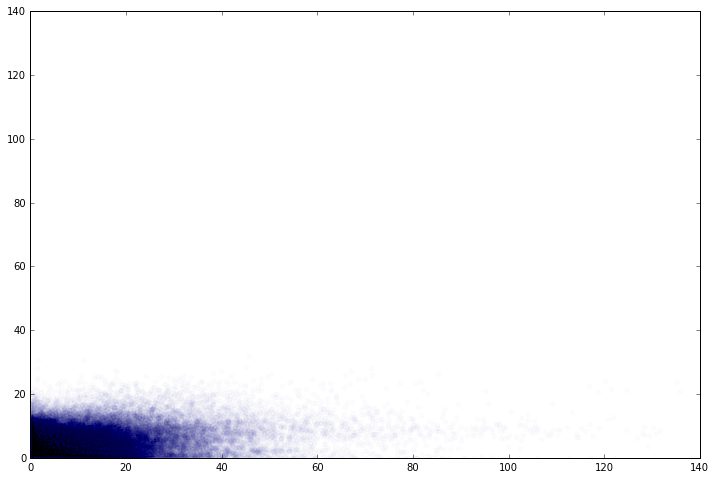

In [157]:
yclass = cnn_classify.predict(Xtest)
ypred = cnn_reg.predict(Xtest)

yhat = scale_y.inverse_transform(ypred) / 10
ytest_true = scale_y.inverse_transform(Ytest) / 10

yhat *= yclass > 0.5

from scipy.stats import pearsonr, spearmanr

print "Test Mean %f, Std: %f" % (yhat.mean(), ytest_true.std())
print "Prediction Mean %f, Std: %f" % (yhat.mean(), ytest_true.std())
print "Yhat shape", yhat.shape, "Ytest shape", Ytest.shape

print spearmanr(yhat.flatten(), ytest_true.flatten())
print "Pearson", pearsonr(yhat.flatten(), ytest_true.flatten())
print "RMSE:", np.mean((yhat - ytest_true)**2)**(0.5)

plt.figure(figsize=(12, 8))
plt.scatter(ytest_true, yhat, alpha=0.01)
plt.xlim([0, 140])
plt.ylim([0, 140])




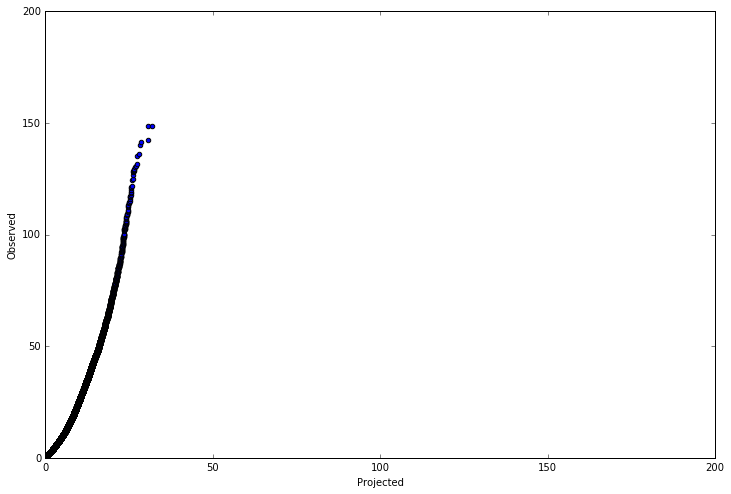

In [158]:
import scipy
def qqplot(x, y, ax=None, **kwargs):
    _, xr = scipy.stats.probplot(x, fit=False)
    _, yr = scipy.stats.probplot(y, fit=False)
    if ax is None:
        plt.scatter(xr, yr, **kwargs)
    else:
        ax.scatter(xr, yr, **kwargs)
        
        
plt.figure(figsize=(12,8))
qqplot(yhat.flatten(), ytest_true.flatten())
plt.ylim([0, 200])
plt.xlim([0, 200])
plt.xlabel("Projected")
plt.ylabel("Observed")


# To Netcdf

In [111]:
dfdata = []
print ypred.shape, Ytest.shape, locs.shape, t.shape
for j, (lat, lon) in enumerate(locs.values):
    for i, t1 in enumerate(ttest.values):
        d = dict(lat=lat, lon=lon, time=t1, projected=yhat[i,j], ground_truth=YtestTrue[i,j])
        dfdata.append(d)
df = pd.DataFrame(dfdata)
df.set_index(["lat", "lon", "time"], inplace=True)
dfx = xr.Dataset.from_dataframe(df)
dfx


(920, 266) (920, 266) (266, 2) (3220,)


<xray.Dataset>
Dimensions:       (lat: 24, lon: 27, time: 920)
Coordinates:
  * lat           (lat) float64 41.12 41.38 41.62 41.88 42.12 42.38 42.62 ...
  * lon           (lon) float64 286.4 286.6 286.9 287.1 287.4 287.6 287.9 ...
  * time          (time) datetime64[ns] 2005-06-01 2005-06-02 2005-06-03 ...
Data variables:
    ground_truth  (lat, lon, time) float64 0.0 0.0 0.0 87.98 0.6216 0.0 ...
    projected     (lat, lon, time) float64 0.8872 1.732 6.583 4.783 -0.6235 ...

In [112]:
dfx['error'] = dfx.projected - dfx.ground_truth
print dfx
dfx.to_netcdf("/Users/tj/repos/pydownscale/scripts/results-data/%s/CNN_D_%s.nc" % (seas, seas))




<xray.Dataset>
Dimensions:       (lat: 24, lon: 27, time: 920)
Coordinates:
  * lat           (lat) float64 41.12 41.38 41.62 41.88 42.12 42.38 42.62 ...
  * lon           (lon) float64 286.4 286.6 286.9 287.1 287.4 287.6 287.9 ...
  * time          (time) datetime64[ns] 2005-06-01 2005-06-02 2005-06-03 ...
Data variables:
    ground_truth  (lat, lon, time) float64 0.0 0.0 0.0 87.98 0.6216 0.0 ...
    projected     (lat, lon, time) float64 0.8872 1.732 6.583 4.783 -0.6235 ...
    error         (lat, lon, time) float64 0.8872 1.732 6.583 -83.2 -1.245 ...
